# Physics-Informed Neural Networks (PINNs) for solving the Forward Kolmogorov Equation
## Author
- **Name**: Azimov Sherkhon Azizkhon Ugli
- **Email**: sherkhonazim@gmail.com
- **GitHub**: @AzimovSherkhon


In [1]:
import torch
import numpy as np
from torch import nn, optim
import torch.nn.init as init
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.current_device()} - {torch.cuda.get_device_name(0)}")

torch.manual_seed(1111)

domain_length, num_points, time_step, time_start, time_end = 2.0, 1024, 0.01, 0.0, 1.0
num_time_steps = int(time_end / time_step) + 1
learning_rate, max_iterations = 0.05, 2000

x_coords = torch.linspace(-domain_length, domain_length, num_points, requires_grad=True, device=device)
t_coords = torch.linspace(time_start, time_end, num_time_steps, requires_grad=True, device=device)
x_grid, t_grid = torch.meshgrid(x_coords, t_coords, indexing="ij")
x_flat, t_flat = x_grid.reshape(-1, 1), t_grid.reshape(-1, 1)  # Already on device
hidden_units = 10

def create_mlp():
    return nn.Sequential(
        nn.Linear(2, hidden_units), nn.SiLU(),
        nn.Linear(hidden_units, hidden_units), nn.SiLU(),
        nn.Linear(hidden_units, hidden_units), nn.SiLU(),
        nn.Linear(hidden_units, hidden_units), nn.SiLU(),
        nn.Linear(hidden_units, 1), nn.Softplus()
    ).to(device)

model = create_mlp()
optimizer = optim.LBFGS(model.parameters(), lr=learning_rate)

def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            init.zeros_(layer.bias)

model.apply(initialize_weights)

def compute_derivative(output, input_var):
    return torch.autograd.grad(output, input_var, grad_outputs=torch.ones_like(output, device=device), create_graph=True)[0]

def compute_loss(x, t):
    inputs = torch.cat((x, t), 1)
    initial_inputs = torch.cat((x, 0 * t), 1)
    left_boundary = torch.cat((-domain_length + 0 * x, t), 1)
    right_boundary = torch.cat((domain_length + 0 * x, t), 1)

    solution = model(inputs)
    solution_t = compute_derivative(solution, t)
    solution_x = compute_derivative(solution, x)
    solution_xx = compute_derivative(solution_x, x)

    pde_residual = solution_t - (12 * x**2 - 4) * solution - 4 * x * (x**2 - 1) * solution_x - 0.405 * solution_xx
    initial_pdf = (1 / torch.tensor(14.813, device=device)) * torch.exp(-(2 * x**2) * (x**2 - 2) / torch.tensor(0.9, device=device)**2)
    initial_residual = model(initial_inputs) - initial_pdf

    left_bc_solution = model(left_boundary)
    right_bc_solution = model(right_boundary)
    left_bc_deriv = compute_derivative(left_bc_solution, left_boundary)
    right_bc_deriv = compute_derivative(right_bc_solution, right_boundary)

    return (pde_residual**2).mean() + 10 * (initial_residual**2).mean() + 100 * (left_bc_deriv**2).mean() + 100 * (right_bc_deriv**2).mean()

def closure():
    loss = compute_loss(x_flat, t_flat)
    optimizer.zero_grad()
    loss.backward()
    return loss

start_time = time.time()
loss_history, min_loss, best_model_weights = [], float('inf'), None
patience, loss_threshold, stagnant_count = 20, 1e-8, 0

for iteration in range(max_iterations):
    current_loss = optimizer.step(closure).item()
    loss_history.append(current_loss)

    if current_loss < min_loss:
        min_loss = current_loss
        best_model_weights = model.state_dict()

    if len(loss_history) > 1 and abs(loss_history[-1] - loss_history[-2]) < loss_threshold:
        stagnant_count += 1
        if stagnant_count >= patience:
            print(f"Early stopping at iteration {iteration} with loss: {current_loss:.2e}")
            break
    else:
        stagnant_count = 0

    if iteration % 100 == 0:
        print(f"Epoch {iteration:3d}: Current loss: {current_loss:.2e}")

if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print(f"Loaded best model with loss: {min_loss:.2e}")

training_duration = time.time() - start_time
print(f"Training completed in {training_duration:.2f} seconds.")
loss_history = np.array(loss_history)

Device in use: cuda
CUDA available: True
CUDA device: 0 - NVIDIA GeForce RTX 3060
Epoch   0: Current loss: 1.60e+02
Early stopping at iteration 87 with loss: 5.04e-06
Loaded best model with loss: 5.04e-06
Training completed in 83.74 seconds.


In [5]:
import torch
import numpy as np
from torch import nn, optim
import torch.nn.init as init
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.current_device()} - {torch.cuda.get_device_name(0)}")

torch.manual_seed(1111)

domain_length, num_points, time_step, time_start, time_end = 2.0, 1024, 0.01, 0.0, 1.0
num_time_steps = int(time_end / time_step) + 1
learning_rate, max_iterations = 0.05, 2000

x_coords = torch.linspace(-domain_length, domain_length, num_points, requires_grad=True)
t_coords = torch.linspace(time_start, time_end, num_time_steps, requires_grad=True)
x_grid, t_grid = torch.meshgrid(x_coords, t_coords, indexing="ij")
x_flat, t_flat = x_grid.reshape(-1, 1).to(device), t_grid.reshape(-1, 1).to(device)
hidden_units = 10

def create_mlp():
    return nn.Sequential(
        nn.Linear(2, hidden_units), nn.SiLU(),
        nn.Linear(hidden_units, hidden_units), nn.SiLU(),
        nn.Linear(hidden_units, hidden_units), nn.SiLU(),
        nn.Linear(hidden_units, hidden_units), nn.SiLU(),
        nn.Linear(hidden_units, 1), nn.Softplus()
    ).to(device)

model = create_mlp()
optimizer = optim.LBFGS(model.parameters(), lr=learning_rate)

def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            init.zeros_(layer.bias)

model.apply(initialize_weights)

def compute_derivative(output, input_var):
    return torch.autograd.grad(output, input_var, grad_outputs=torch.ones_like(output), create_graph=True)[0]

def compute_loss(x, t):
    inputs = torch.cat((x, t), 1)
    initial_inputs = torch.cat((x, 0 * t), 1)
    left_boundary = torch.cat((-domain_length + 0 * x, t), 1)
    right_boundary = torch.cat((domain_length + 0 * x, t), 1)

    solution = model(inputs)
    solution_t = compute_derivative(solution, t)
    solution_x = compute_derivative(solution, x)
    solution_xx = compute_derivative(solution_x, x)

    pde_residual = solution_t - (12 * x**2 - 4) * solution - 4 * x * (x**2 - 1) * solution_x - 0.405 * solution_xx
    initial_pdf = (1 / torch.tensor(14.813, device=device)) * torch.exp(-(2 * x**2) * (x**2 - 2) / torch.tensor(0.9, device=device)**2)
    initial_residual = model(initial_inputs) - initial_pdf

    left_bc_solution, right_bc_solution = model(left_boundary), model(right_boundary)
    left_bc_deriv, right_bc_deriv = compute_derivative(left_bc_solution, left_boundary), compute_derivative(right_bc_solution, right_boundary)

    return (pde_residual**2).mean() + 10 * (initial_residual**2).mean() + 100 * (left_bc_deriv**2).mean() + 100 * (right_bc_deriv**2).mean()

def closure():
    loss = compute_loss(x_flat, t_flat)
    optimizer.zero_grad()
    loss.backward()
    return loss

start_time = time.time()
loss_history, min_loss, best_model_weights = [], float('inf'), None
patience, loss_threshold, stagnant_count = 20, 1e-8, 0

for iteration in range(max_iterations):
    current_loss = optimizer.step(closure).item()
    loss_history.append(current_loss)

    if current_loss < min_loss:
        min_loss = current_loss
        best_model_weights = model.state_dict()

    if len(loss_history) > 1 and abs(loss_history[-1] - loss_history[-2]) < loss_threshold:
        stagnant_count += 1
        if stagnant_count >= patience:
            print(f"Early stopping at iteration {iteration} with loss: {current_loss:.2e}")
            break
    else:
        stagnant_count = 0

    if iteration % 100 == 0:
        print(f"Epoch {iteration:3d}: Current loss: {current_loss:.2e}")

if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print(f"Loaded best model with loss: {min_loss:.2e}")

training_duration = time.time() - start_time
print(f"Training completed in {training_duration:.2f} seconds.")
loss_history = np.array(loss_history)

Epoch   0: Current loss: 1.60e+02
Early stopping at iteration 87 with loss: 6.65e-06
Loaded best model with loss: 6.65e-06
Training completed in 106.83 seconds.


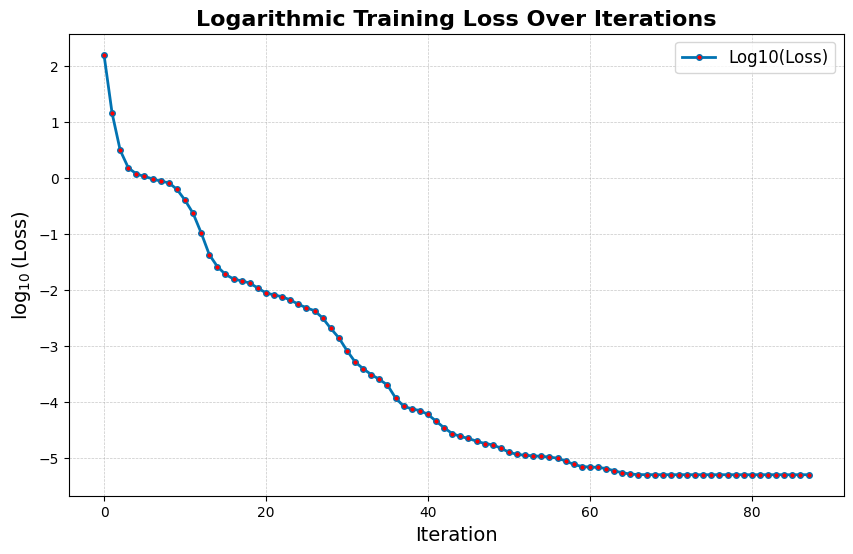

In [5]:
import matplotlib.pyplot as plt
# Plotting training loss
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(loss_history)), np.log10(loss_history),
    label="Log10(Loss)", color="#0173b2", linewidth=2,
    linestyle="-", marker="o", markersize=4, markerfacecolor="red"
)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel(r"$\log_{10}(\text{Loss})$", fontsize=14)
plt.title("Logarithmic Training Loss Over Iterations", fontsize=16, fontweight="bold")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc="upper right")
plt.savefig("Log10_Loss_Plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [6]:
# Generate PINN predictions
x_coords_pred = torch.linspace(-domain_length, domain_length, num_points)
t_coords_pred = torch.linspace(time_start, time_end, num_time_steps)
x_grid_pred, t_grid_pred = torch.meshgrid(x_coords_pred, t_coords_pred, indexing="ij")
x_flat_pred, t_flat_pred = x_grid_pred.reshape(-1, 1), t_grid_pred.reshape(-1, 1)
inputs_pred = torch.cat((x_flat_pred, t_flat_pred), 1).to(device)

pinn_prediction = model(inputs_pred).reshape(num_points, num_time_steps).cpu().detach().numpy()

# Normalize PINN predictions
x_coords_np = np.linspace(-domain_length, domain_length, num_points)
spatial_step = x_coords_np[1] - x_coords_np[0]
for time_idx in range(pinn_prediction.shape[1]):
    pinn_prediction[:, time_idx] /= np.sum(pinn_prediction[:, time_idx]) * spatial_step


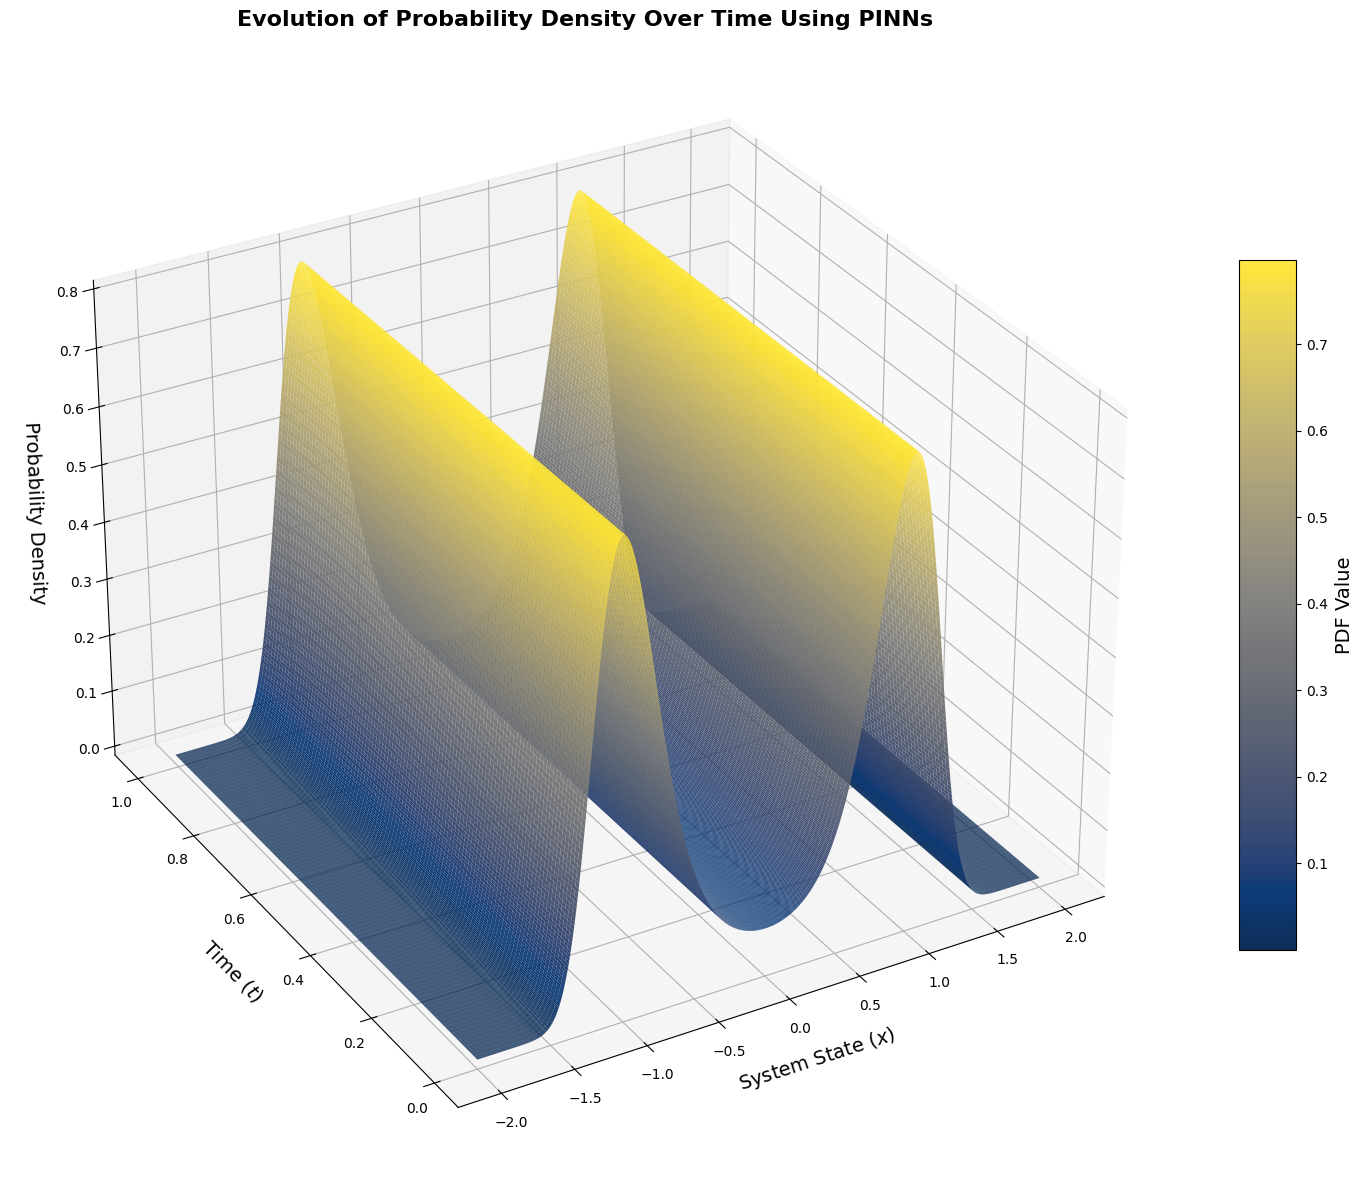

In [7]:
x_coords_np = np.linspace(-domain_length, domain_length, num_points)
t_coords_np = np.linspace(time_start, time_step * pinn_prediction.shape[1], pinn_prediction.shape[1])
X, T = np.meshgrid(x_coords_np, t_coords_np, indexing="ij")

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(
    X, T, pinn_prediction, cmap="cividis",
    edgecolor="none", rstride=1, cstride=1, alpha=0.95
)

ax.set_xlabel("System State ($x$)", fontsize=14, labelpad=10)
ax.set_ylabel("Time ($t$)", fontsize=14, labelpad=10)
ax.set_zlabel("Probability Density", fontsize=14, labelpad=10)
ax.zaxis.label.set_rotation(180)
ax.set_title("Evolution of Probability Density Over Time Using PINNs", fontsize=16, fontweight="bold", pad=1)

colorbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=12, pad=0.05)
colorbar.set_label("PDF Value", fontsize=14, labelpad=5)

ax.view_init(elev=30, azim=240)
ax.tick_params(axis="both", which="major", labelsize=10)
plt.tight_layout()
plt.savefig("PINN_PDF_Evolution.png", dpi=300, bbox_inches="tight")
plt.show()

In [8]:
fdm_solution = np.load('pdf_FDM_0_1.npy')

difference_abs = np.abs(pinn_prediction - fdm_solution)
max_diff_value = np.max(difference_abs)
max_diff_position = np.unravel_index(np.argmax(difference_abs), difference_abs.shape)

print("Maximum difference value:", max_diff_value)
print("Position of maximum difference (row, column):", max_diff_position)

Maximum difference value: 0.00031372450859169787
Position of maximum difference (row, column): (np.int64(529), np.int64(0))


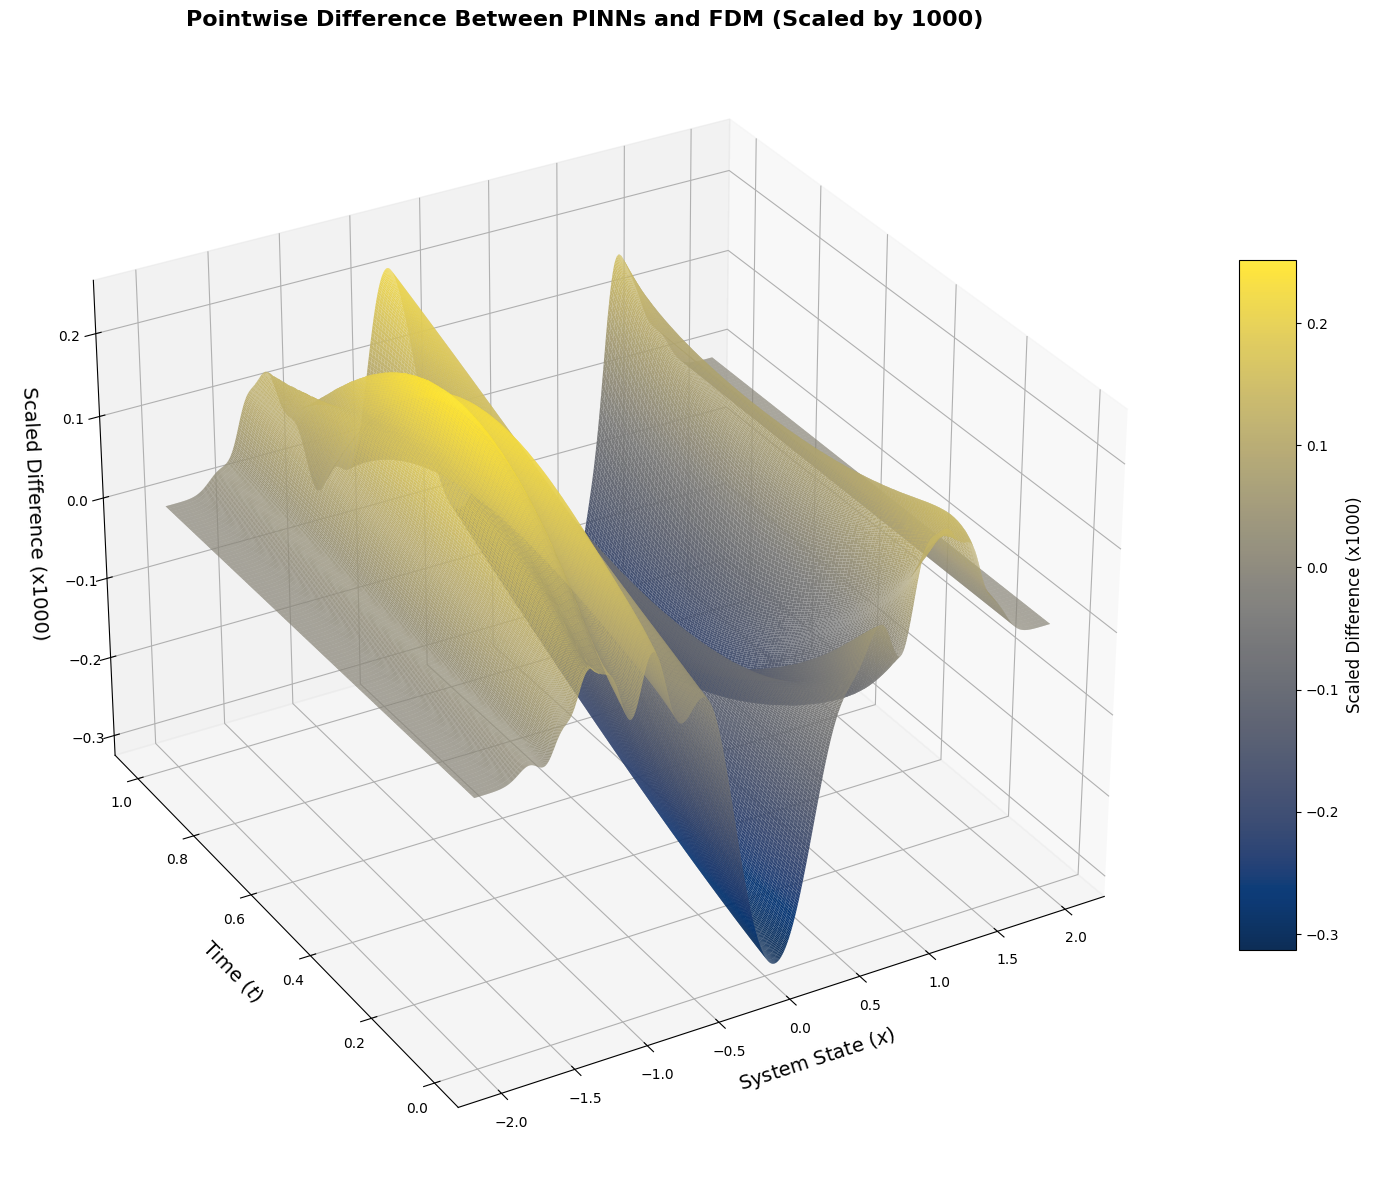

In [9]:
x_coords_np = np.linspace(-domain_length, domain_length, num_points)
t_coords_np = np.linspace(time_start, time_step * pinn_prediction.shape[1], pinn_prediction.shape[1])
X, T = np.meshgrid(x_coords_np, t_coords_np, indexing="ij")
difference = pinn_prediction - fdm_solution
multiplier = 1000
scaled_difference = difference * multiplier

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(
    X, T, scaled_difference, cmap="cividis",
    edgecolor="none", rstride=1, cstride=1, alpha=0.95
)

ax.set_xlabel("System State ($x$)", fontsize=14, labelpad=10)
ax.set_ylabel("Time ($t$)", fontsize=14, labelpad=10)
ax.set_zlabel(f"Scaled Difference (x{multiplier})", fontsize=14, labelpad=10)
ax.set_title(f"Pointwise Difference Between PINNs and FDM (Scaled by {multiplier})", fontsize=16, fontweight="bold", pad=1)

colorbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=12, pad=0.05)
colorbar.set_label(f"Scaled Difference (x{multiplier})", fontsize=12, labelpad=5)

ax.view_init(elev=30, azim=240)
ax.tick_params(axis="both", which="major", labelsize=10)
plt.tight_layout()
plt.savefig("Scaled_Difference_PINNs_FDM.png", dpi=300, bbox_inches="tight")
plt.show()